## Task : Compare Gradient Descent, Mini-Batch Gradient Descent, Gradient Descent with Momentum,  Adam optimization methods.

In [44]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io
import sklearn
import sklearn.datasets
import math

from nn_util import * 
%matplotlib inline

## 1. Gradient Descent 

 The gradient descent rule is, for $l = 1, ..., L$: $$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$ $$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

where L is the number of layers and $\alpha$ is the learning rate. All parameters should be stored in the parameters dictionary. Note that the iterator l starts at 0 in the for loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift l to l+1 when coding.

In [45]:
def update_parameters_with_gd(params,grads,learning_rate) :
    
    L = len(params)//2
    for l in range(L) : 
        params['w' + str(l+1)] = params['w' + str(l+1)] - learning_rate*grads['dw' + str(l+1)]
        params['b' + str(l+1)] = params['b' + str(l+1)] - learning_rate*grads['db' + str(l+1)]
        
    return params

### Stochastic Gradient Descent (SGD)

A variant of this is Stochastic Gradient Descent (SGD), which is equivalent to mini-batch gradient descent where each mini-batch has just 1 example. The update rule that you have just implemented does not change. What changes is that you would be computing gradients on just one training example at a time, rather than on the whole training set. The code examples below illustrate the difference between stochastic gradient descent and (batch) gradient descent.

    (Batch) Gradient Descent:
 
X = data_input<br>
Y = labels<br>
parameters = initialize_parameters(layers_dims)<br>
for i in range(0, num_iterations):<br>
    # Forward propagation<br>
    a, caches = forward_propagation(X, parameters)<br>
    # Compute cost.<br>
    cost += compute_cost(a, Y)<br>
    # Backward propagation.<br>
    grads = backward_propagation(a, caches, parameters)<br>
    # Update parameters.<br>
    parameters = update_parameters(parameters, grads)<br>

    Stochastic Gradient Descent:

X = data_input<br>
Y = labels<br>
parameters = initialize_parameters(layers_dims)<br>
for i in range(0, num_iterations):<br>
    for j in range(0, m):<br>
        # Forward propagation<br>
        a, caches = forward_propagation(X[:,j], parameters)<br>
        # Compute cost<br>
        cost += compute_cost(a, Y[:,j])<br>
        # Backward propagation<br>
        grads = backward_propagation(a, caches, parameters)<br>
        # Update parameters.<br>
        parameters = update_parameters(parameters, grads)<br>





In Stochastic Gradient Descent, you use only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly. Here is an illustration of this:


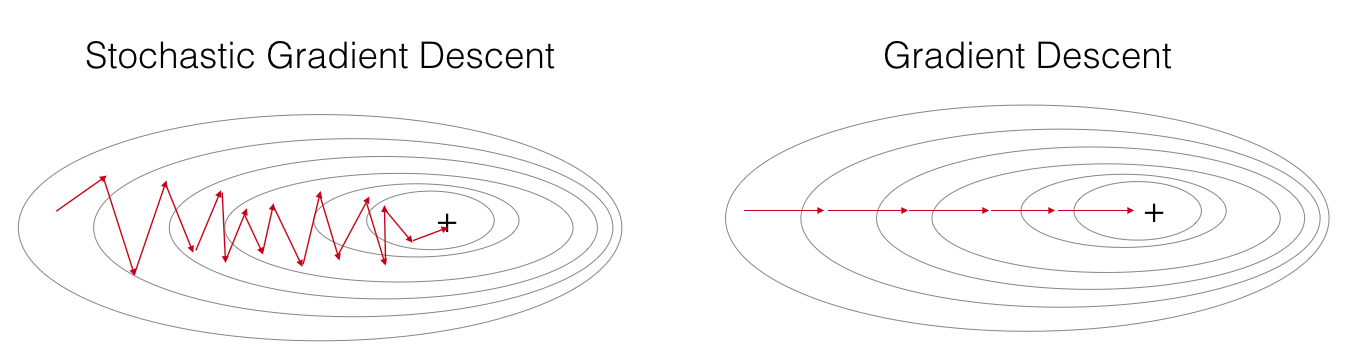

Note also that implementing SGD requires 3 for-loops in total:

   1. Over the number of iterations
   2. Over the $m$ training examples
   3. Over the layers (to update all parameters, from $(W^{[1]},b^{[1]})$ to $(W^{[L]},b^{[L]})$)

In practice, you'll often get faster results if you do not use neither the whole training set, nor only one training example, to perform each update. Mini-batch gradient descent uses an intermediate number of examples for each step. With mini-batch gradient descent, you loop over the mini-batches instead of looping over individual training examples.
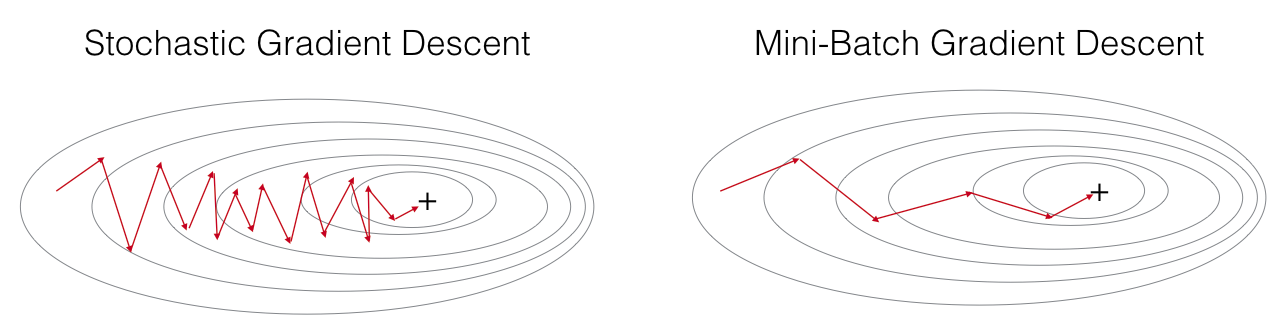

    The difference between gradient descent, mini-batch gradient descent and stochastic gradient descent is the number of examples you use to perform one update step.
    You have to tune a learning rate hyperparameter $\alpha$.
    With a well-turned mini-batch size, usually it outperforms either gradient descent or stochastic gradient descent (particularly when the training set is large).



## 2. Mini Batch Gradient Descent

There are two steps:

   1. **Shuffle** : Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches.


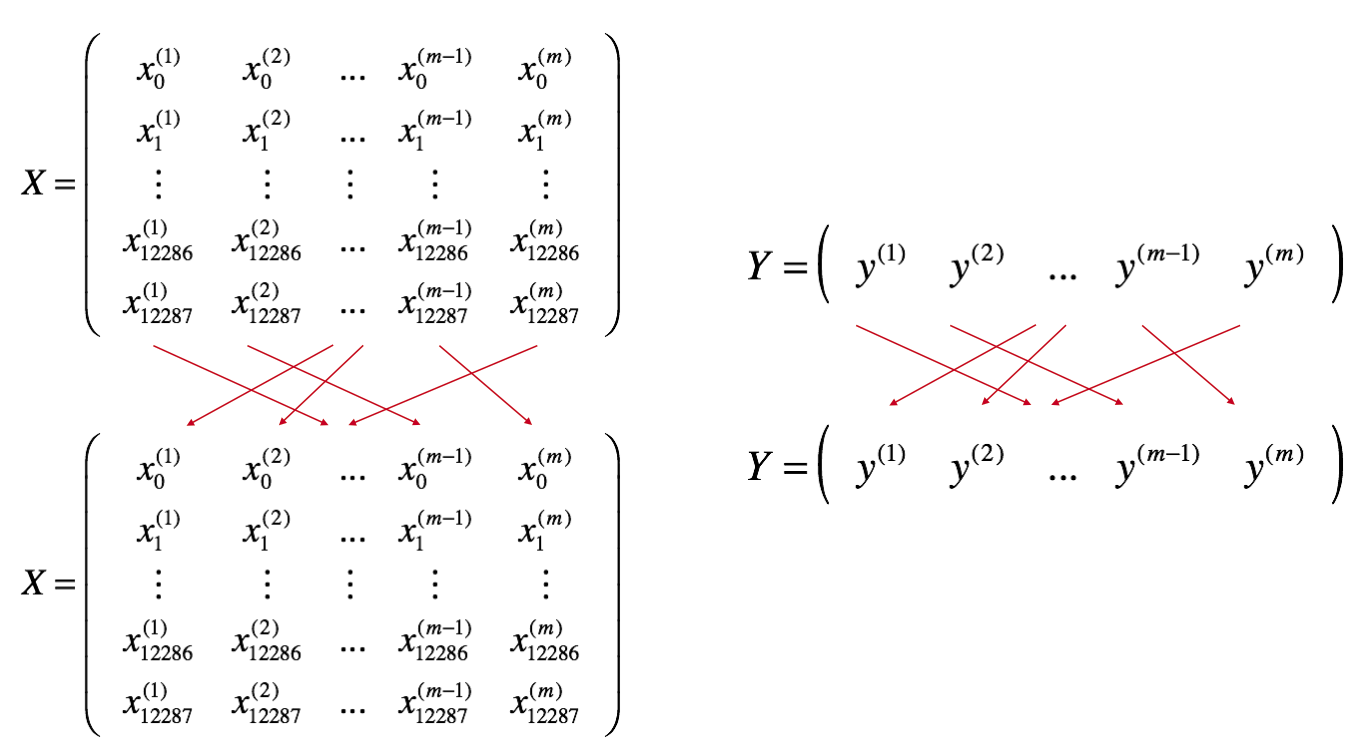

2. **Partition**: Partition the shuffled (X, Y) into mini-batches of size mini_batch_size (here 64). Note that the number of training examples is not always divisible by mini_batch_size. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full mini_batch_size, it will look like this: 

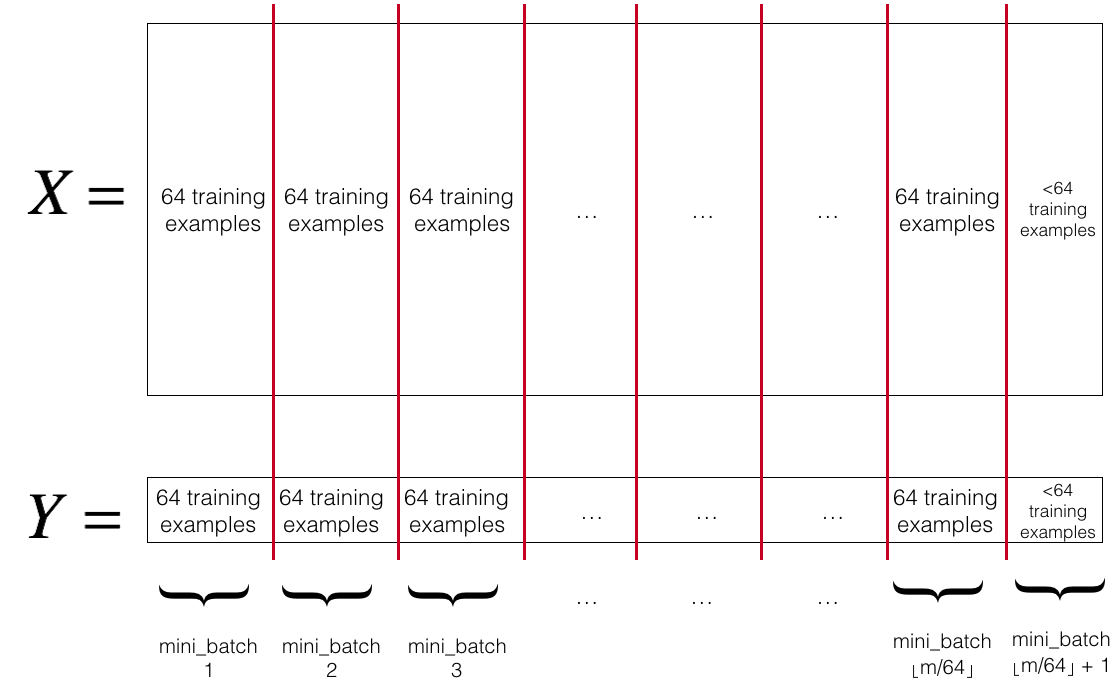

In [46]:
def mini_batches_generator(X,Y,mini_batch_size = 64, seed = 0) : 
    
    np.random.seed(seed)
    m =X.shape[1]
    mini_batches = []
    
    # Shuffling step 
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation].reshape((1,m))
    
    # Partitioning step
    num_complete_minibatches = math.floor(m/mini_batch_size)
    
    for k in range(0,num_complete_minibatches) : 
        
        minibatch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        minibatch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        
        mini_batch =(minibatch_X,minibatch_Y)
        mini_batches.append(mini_batch)
        
    # for last most probaly incomplete mini_batch 
    if m % mini_batch_size != 0 :
        mini_batch_X = shuffled_X[:,int(m/mini_batch_size) : ]
        mini_batch_Y = shuffled_Y[:,int(m/mini_batch_size) : ]
        minibatch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(minibatch)
        
    return mini_batches

## 3. GD with Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.

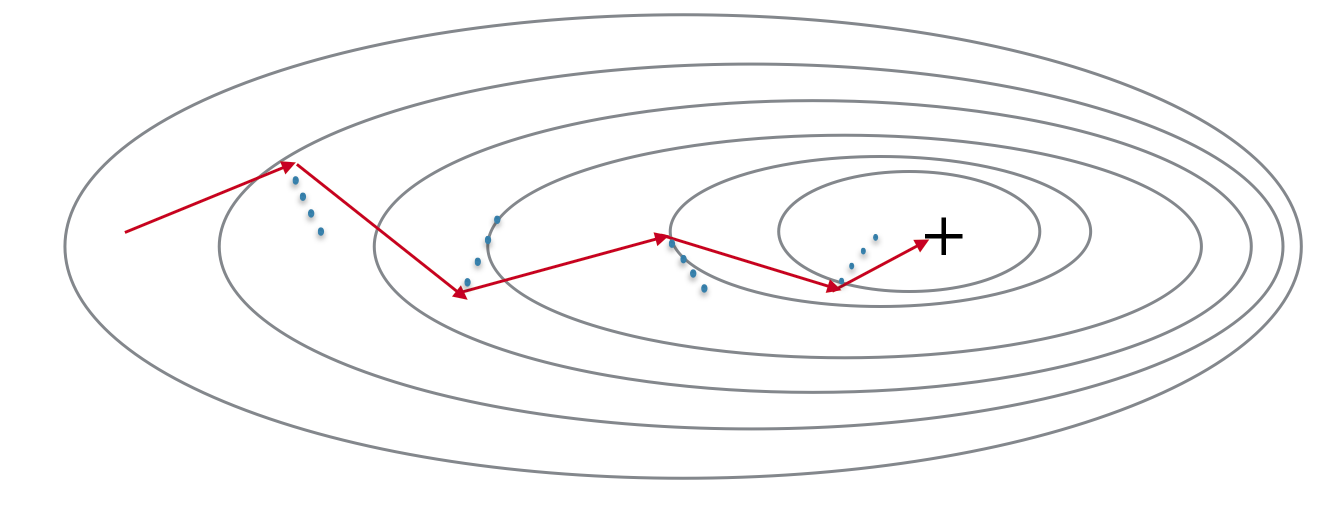

In [60]:
def initialize_velocity(params) : 
    
    L = len(params)//2

    v = {}
    
    for l in range(L) : 
        v['dw' + str(l+1)] = np.zeros((params['w' + str(l+1)].shape[0],params['w' + str(l+1)].shape[1]))
        v['db' + str(l+1)] = np.zeros((params['b' + str(l+1)].shape[0],params['b' + str(l+1)].shape[1]))
    return v

In [61]:
def update_parameters_with_momentum(params,grads,learning_rate,beta,v) :
    
    L = len(params)//2
    
    for l in range(L) : 
        
        # fetching v and computing velocities with exponential weighted average formula
        v['dw' + str(l+1)] = beta*v['dw' + str(l+1)] + (1-beta)*grads['dw' + str(l+1)]
        v['db' + str(l+1)] = beta*v['db' + str(l+1)] + (1-beta)*grads['db' + str(l+1)]
        
        # updating the parameters
        params['w' + str(l+1)] = params['w' + str(l+1)] - learning_rate * v['dw' + str(l+1)]
        params['b' + str(l+1)] = params['b' + str(l+1)] - learning_rate * v['db' + str(l+1)]

    return params,v



**Note that:**

  *  The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
    If $\beta = 0$, then this just becomes standard gradient descent without momentum.

**How do you choose $\beta$?**

   * The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much.
   * Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default.
   * Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$.

   * Momentum takes past gradients into account to smooth out the steps of gradient descent. It can be applied with batch gradient descent, mini-batch gradient descent or stochastic gradient descent.
   * You have to tune a momentum hyperparameter $\beta$ and a learning rate $\alpha$.



## 4. Adam 

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum.

How does Adam work?

   1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction).
   2. It calculates an exponentially weighted average of the squares of the past gradients, and stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction).
   3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$:
$$\begin{cases} v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\ v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\ s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\ s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\ W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon} \end{cases}$$

where:

   * t counts the number of steps taken of Adam
   * L is the number of layers
   * $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages.
   * $\alpha$ is the learning rate
   * $\varepsilon$ is a very small number to avoid dividing by zero


In [73]:
def initialize_adam(params) : 
    
    L = len(params)//2
    v = {}
    s = {}
    
    for l in range(L) : 
        v['dw' + str(l+1)] = np.zeros((params['w' + str(l+1)].shape[0],params['w' + str(l+1)].shape[1]))
        v['db' + str(l+1)] = np.zeros((params['b' + str(l+1)].shape[0],params['b' + str(l+1)].shape[1]))
        s['dw' + str(l+1)] = np.zeros((params['w' + str(l+1)].shape[0],params['w' + str(l+1)].shape[1]))
        s['db' + str(l+1)] = np.zeros((params['w' + str(l+1)].shape[0],params['b' + str(l+1)].shape[1]))
    return v,s

In [80]:
def update_parameters_with_adam(params,grads,v,s,t,learning_rate=0.01,beta=0.9,beta2=0.999,epsilon = 1e-8) :
    
    L = len(params)//2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L) : 
        
        # Computing moving average of gradients
        v['dw' + str(l+1)] = beta * (v['dw' + str(l+1)]) + (1-beta) * grads['dw' + str(l+1)]
        v['db' + str(l+1)] = beta * (v['db' + str(l+1)]) + (1-beta) * grads['db' + str(l+1)]
        
        # Compute bias-corrected first moment estimate
        v_corrected['dw' + str(l+1)] = v['dw' + str(l+1)]/(1-beta**t)
        v_corrected['db' + str(l+1)] = v['db' + str(l+1)]/(1-beta**t)
        
        # Computing moving average of squared gradients
        s['dw' + str(l+1)] = beta2 * (s['dw' + str(l+1)]) + (1-beta2) * np.square(grads['dw' + str(l+1)])
        s['db' + str(l+1)] = beta2 * (s['db' + str(l+1)]) + (1-beta2) * np.square(grads['db' + str(l+1)])
        
        # Compute bias-corrected second raw moment estimate
        s_corrected['dw' + str(l+1)] = s['dw' + str(l+1)]/(1-beta2**t)
        s_corrected['db' + str(l+1)] = s['db' + str(l+1)]/(1-beta2**t)
        
        # Update parameters
        params['w' + str(l+1)] = params['w' + str(l+1)] - learning_rate * v_corrected['dw' + str(l+1)]/(np.sqrt(s_corrected['dw' + str(l+1)]) + epsilon)
        params['b' + str(l+1)] = params['b' + str(l+1)] - learning_rate * v_corrected['db' + str(l+1)]/(np.sqrt(s_corrected['db' + str(l+1)]) + epsilon)
                                                                            
    return params,v,s

##  Comparing model with different optimization algorithms

In [81]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

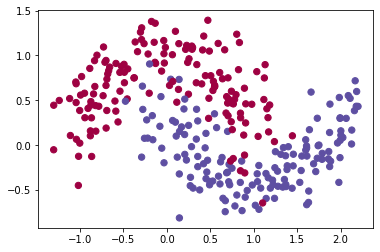

In [82]:
train_X,train_Y = load_dataset()

In [83]:
def initialize_params(layers_dims) : 
    np.random.seed(3)
    params = {}
    L = len(layers_dims)
    for l in range(1,L) : 
        params['w' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])*(np.sqrt(2/layers_dims[l-1]))
        params['b' + str(l)] = np.zeros((layers_dims[l],1))
    return params

## 3 Layer Neural Network Model

In [84]:
def model(X,Y,layers_dims,optimizer,learning_rate = 0.0007,mini_batch_size = 64,beta = 0.9,beta2 = 0.999, epsilon = 1e-8,epochs = 10000,print_cost = True) : 

    L = len(layers_dims) 
    costs = []
    t = 0
    seed = 10 # Having a specific set of random mini batches from the minibatch_generator function
    m = X.shape[1]
    
    # Initializing parameters
    params = initialize_params(layers_dims)
    
    # Setting up the optimizer
    if optimizer == 'gd':
        pass # no initialization required , just straight up updation 
    if optimizer == 'momentum' : 
        v = initialize_velocity(params)
    if optimizer == 'adam' : 
        v,s = initialize_adam(params)
    
    for i in range(epochs) : 
        
        # incrementing seed to reshuffle the dataset after every epoch
        seed = seed + 1
        minibatches = mini_batches_generator(X,Y,mini_batch_size,seed)
        cost_total = 0
        
        for mini_batch in minibatches : 
            
            # selecting a mini batch
            (minibatch_X,minibatch_Y) = mini_batch
            
            # Forward prop
            a3,cache = forward_prop(minibatch_X,params)
        
            # Computing cost    
            cost_total += compute_cost(a3,minibatch_Y)
            
            # Backward prop
            grads = backward_prop(minibatch_X,minibatch_Y,cache)
            
            # Updating parameters
            if optimizer == 'gd' :
                params = update_parameters_with_gd(params,grads,learning_rate)
            elif optimizer == 'momentum' : 
                params,v = update_parameters_with_momentum(params,grads,learning_rate,beta,v)
            elif optimizer == 'adam' : 
                # adam counter
                t = t + 1
                params,v,s = update_parameters_with_adam(params,grads,v,s,t,learning_rate,beta,beta2,epsilon)
        cost_avg = cost_total/m
        
        # print every 1000 epoch
        if print_cost and i%1000 == 0 : 
            print("Cost after iteration {} : {}".format(i,cost_avg))
            costs.append(cost_avg)

    # plotting loss
    plt.plot(costs)
    plt.xlabel('cost')
    plt.ylabel('epochs per 1000')
    plt.title('Learning rate = ' + str(learning_rate) + ' optimizer = ' + str(optimizer))
    plt.show()
    
    return params
        

## Mini-batch GD model

Cost after iteration 0 : 0.011731793961760247
Cost after iteration 1000 : 0.011099254391063351
Cost after iteration 2000 : 0.010569486719476629
Cost after iteration 3000 : 0.009954558141523587
Cost after iteration 4000 : 0.009544254379127313
Cost after iteration 5000 : 0.009078250818501594
Cost after iteration 6000 : 0.008871200576202736
Cost after iteration 7000 : 0.008672423617308262
Cost after iteration 8000 : 0.00832865492952252
Cost after iteration 9000 : 0.007784322573842481


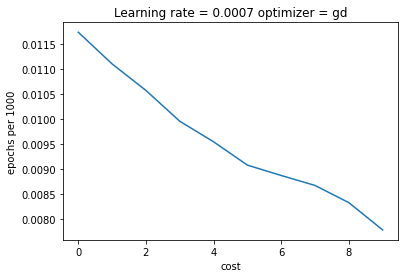

Accuracy: 0.7966666666666666


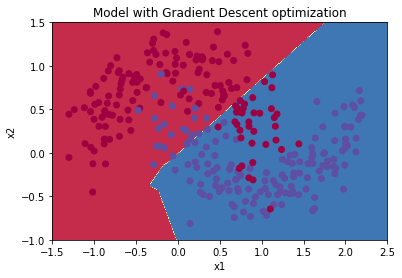

In [70]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Mini-batch GD with momentum model

Cost after iteration 0 : 0.011731981892447688
Cost after iteration 1000 : 0.011100348624259421
Cost after iteration 2000 : 0.010571161392593393
Cost after iteration 3000 : 0.009956285519957246
Cost after iteration 4000 : 0.009545550768343108
Cost after iteration 5000 : 0.009079490394258762
Cost after iteration 6000 : 0.008872572872508023
Cost after iteration 7000 : 0.008673703071617673
Cost after iteration 8000 : 0.008331684459694755
Cost after iteration 9000 : 0.007786891450700552


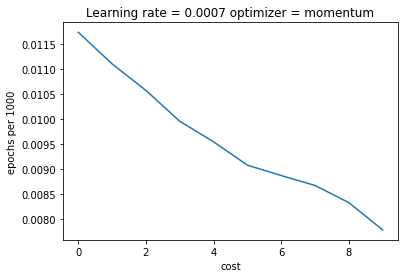

Accuracy: 0.7966666666666666


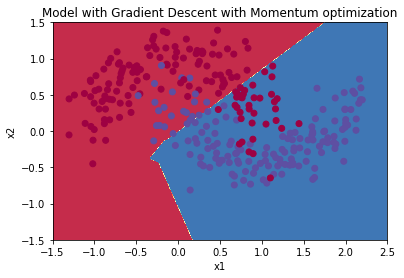

In [71]:
layers_dims = [train_X.shape[0],5,2,1]
params = model(train_X,train_Y,layers_dims,beta = 0.9,optimizer = 'momentum')

# predicting
predictions = predict(train_X,train_Y,params)

# plotting
plt.title('Model with Gradient Descent with Momentum optimization')
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x : predict_dec(params,x.T),train_X, train_Y)

## Mini-batch Adam model

Cost after iteration 0 : 0.011725562168081854
Cost after iteration 1000 : 0.0026578517545046794
Cost after iteration 2000 : 0.0023061475685648212
Cost after iteration 3000 : 0.0024409832945387474
Cost after iteration 4000 : 0.0022748044133348616
Cost after iteration 5000 : 0.0022749060559122034
Cost after iteration 6000 : 0.0022401730516380777
Cost after iteration 7000 : 0.0023860088723540143
Cost after iteration 8000 : 0.0021724736056294848
Cost after iteration 9000 : 0.0019745645662147117


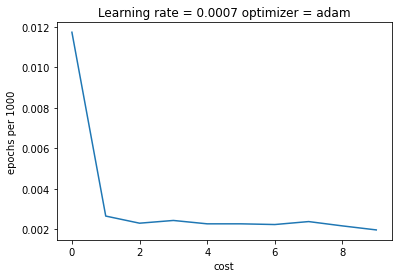

Accuracy: 0.94


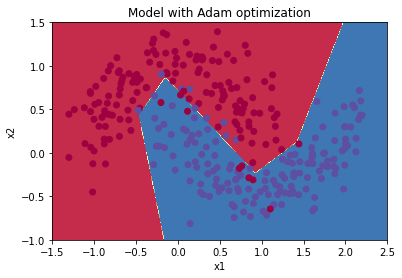

In [85]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Conclusion : 

| **Optimizer                    | **Accuracy**       | **Cost shape**   |
|--------------------------------|--------------------|------------------|
| Gradient Descent               | 79.7%              | oscillations     |
| Gradient Descent with Momentum | 79.7%              | oscillations     |
| Adam                           | 94%                | smoother         |

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligeable. Also, the huge oscillations you see in the cost come from the fact that some minibatches are more difficult thans others for the optimization algorithm.

Adam on the other hand, clearly outperforms mini-batch gradient descent and Momentum. If we run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, we've seen that Adam converges a lot faster.

Some advantages of Adam include:

   * Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum)
   * Usually works well even with little tuning of hyperparameters (except $\alpha$)
